# Multilabel Logistic Regression

In [21]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from metrics.Multilabel_classification_metrics import Precision, Accuracy, Recall, F1Measure, Hamming_Loss

import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score

## Load pickles objects

In [22]:
# Dataframe
path_df = "../Pickles/multilabel_binarizer.pickle"
with open(path_df, 'rb') as data:
    multilabel_binarizer = pickle.load(data)

# features_train
path_features_train = "../Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "../Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "../Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "../Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [23]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [24]:
clf.fit(features_train, labels_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [25]:
y_pred = clf.predict(features_test)

In [26]:
print(y_pred[95])
print(labels_test[95])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [27]:
multilabel_binarizer.inverse_transform(y_pred)[95]

('Non-fiction',)

In [28]:
F1Measure(labels_test, y_pred)

0.3104961559903005

In [29]:
# predict probabilities
y_pred_prob = clf.predict_proba(features_test)

In [30]:
y_pred_prob

array([[0.01017825, 0.01793589, 0.00815324, ..., 0.01297529, 0.01804664,
        0.04415776],
       [0.01769488, 0.07792384, 0.00764847, ..., 0.04392288, 0.06058901,
        0.05600263],
       [0.02650032, 0.00988674, 0.01164094, ..., 0.0910331 , 0.11533457,
        0.30877677],
       ...,
       [0.0360147 , 0.00885977, 0.00801898, ..., 0.03046394, 0.01978787,
        0.27505813],
       [0.05635281, 0.01437091, 0.0042974 , ..., 0.01225468, 0.01350915,
        0.01726619],
       [0.05028899, 0.02696781, 0.00511875, ..., 0.00840662, 0.01050152,
        0.10853951]])

In [31]:
t = 0.2485 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [32]:
# evaluate performance
F1Measure(labels_test, y_pred_new)

0.4998761878832729

In [33]:
# Exact Match Ratio:
accuracy_score(labels_test, y_pred_new)

0.07841001905799075

In [34]:
Accuracy(labels_test, y_pred_new)

0.3922889684052229

In [35]:
Precision(labels_test, y_pred_new)

0.6213569419055397

In [36]:
Recall(labels_test, y_pred_new)

0.4803637872246638

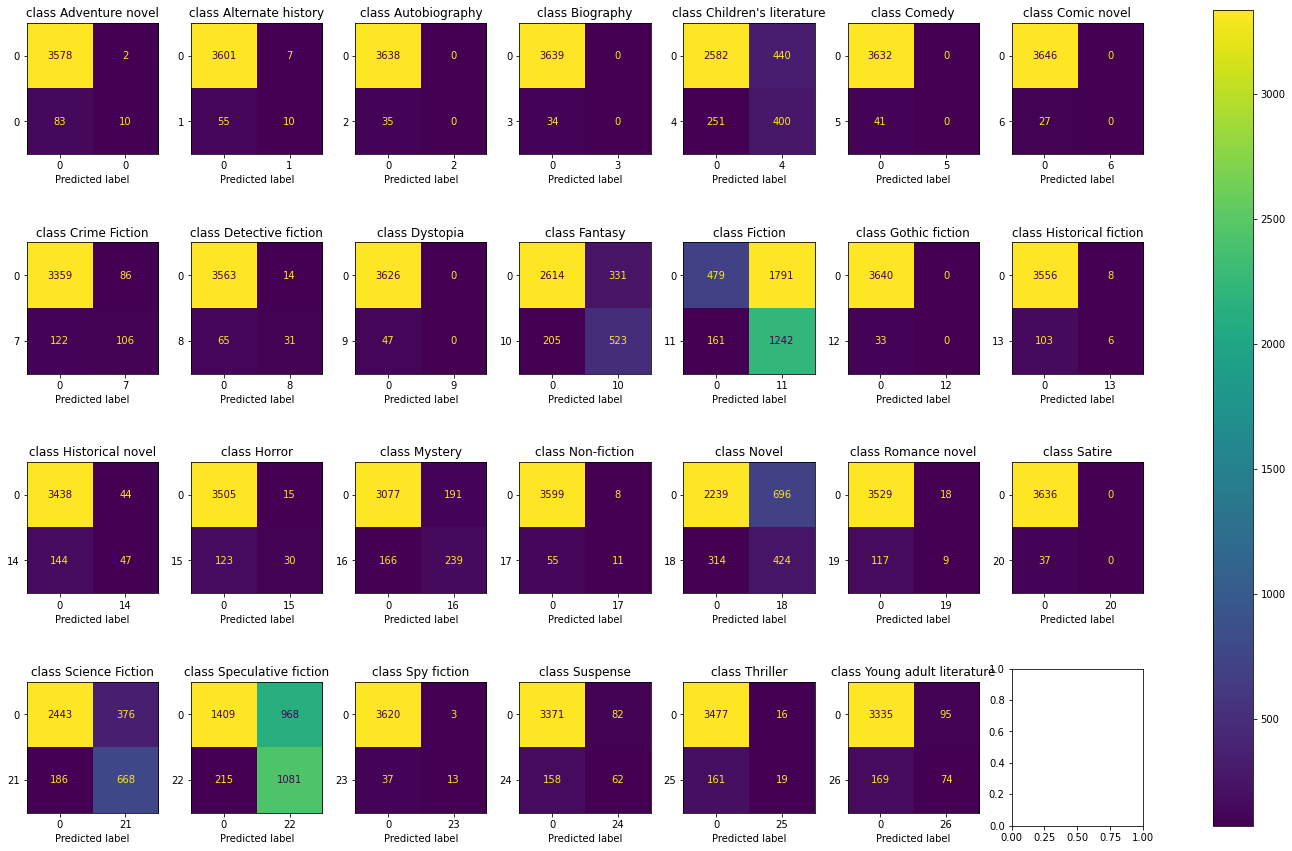

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
classes = multilabel_binarizer.classes_
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(27):
    disp = ConfusionMatrixDisplay(confusion_matrix(labels_test[:, i],
                                                   y_pred_new[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {classes[i]}')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()